In [1]:

import os
import pandas as pd
import numpy as np
import sys

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as patches
import matplotlib.colors as clr

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import fcluster, cophenet
import scipy.cluster.hierarchy as hierarchy
from scipy.cluster.hierarchy import dendrogram



sys.path.append("scripts/")
import scripts.conf as conf
import scripts.oncotree
conf.config_params()
oncotree = scripts.oncotree.Oncotree()

os.makedirs("raw_plots",exist_ok=True)
os.makedirs("source_data",exist_ok=True)

### First, create the source data

In [3]:
gene="EGFR"
#if not(os.path.exists(f"source_data/blueprint_info_{gene}.pickle")):
!python scripts/prepare_blueprint_across_ttypes.py

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6260.16it/s]


In [4]:
# imports

%load_ext autoreload
%autoreload 2

import os
import glob
import gzip
import tqdm
import pickle
import json

import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from matplotlib import gridspec

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import fcluster, cophenet
import scipy.cluster.hierarchy as hierarchy
from scipy.cluster.hierarchy import dendrogram



## Figure 3 c, blueprint of EGFR across tumor types

In [5]:
# distance used for clustering

def mcc_score(x, y):
    
    """Generalization of MCC score to [0, 1] continuous values"""
    
    x = np.array(x)
    y = np.array(y)
    
    tp = np.dot(x, y)
    tn = np.dot(1 - x, 1 - y)
    fp = np.dot(1 - x, y)
    fn = np.dot(x, 1 - y)

    # MCC = TP * TN – FP * FN / √ (TP +FP) * (TP + FN) * (TN + FP) * (TN + FN)
    
    num = (tp * tn) - (fp * fn) 
    den = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    
    return num / den


def mcc_dist(x, y):
    
    return max(1 - mcc_score(x, y), 0)


def round_low(x):
    
    y = abs(x - np.round(x, 3))
    return x - y


def plot_cluster_domains_kde(df, dict_models, gene, output='./', dpi=150, invisible_heatmap=False, plot=True, points=True):
    
    X = list(df.values)
    Y = pdist(X, metric=mcc_dist)

    if len(X) > 1:
        linkage = hierarchy.linkage(Y, method='ward')
    
    
    if gene == 'TP53':
        figsize = (13, 8)
    else:
        figsize = (11, 2)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    gs = gridspec.GridSpec(figure=fig, ncols=2, nrows=2, width_ratios=[15,1], height_ratios=[1,4])
    gs.update(hspace=0.05, wspace=0.00)
    ax0 = plt.subplot(gs[0]) # counts_muts
    ax1 = plt.subplot(gs[1]) # null
    ax2 = plt.subplot(gs[2]) # heatmap
    ax3 = plt.subplot(gs[3]) # right dendogram
        
    # plot dendrogram and display cophenetic distances in ax3
    
    ax3.axis('off')
    
    if len(X) > 1:
        
        ddgram = dendrogram(linkage, truncate_mode=None,
                            labels=list(df.index),
                            color_threshold=0,
                            above_threshold_color='black',
                            orientation="right",
                            get_leaves=True,
                            no_plot=False, ax=ax3)
        
        # capture spread of y-values of dendrogram to adjust later
        
        pool = []
        for item in ddgram['icoord']:
            pool += item
        min_ = min(pool)
        max_ = max(pool)
        
        coph_diam = round_low(ddgram['dcoord'][-1][1])
        # ax3.annotate(xy=(0.6, 0), s=f'cophenetic\ndiameter={np.round(coph_diam, 2)}', fontsize=10)
    
    # Draw domains

    ax1.axis('off')
    ax0.axis('off')
    
    
    ax0.axhline(y=0.0, xmin=0, xmax=len(df.values[0]), 
                ls="-", lw=2,color="black", alpha=0.5, zorder=1)
    fontsize = 8
    if len(df_pfam) >= 6:
        fontsize=6
    eps = 6
    for i, r in df_pfam.sort_values(by='START').iterrows():
        start_base = 9.0 * r['START']
        size_base = 9.0 * r['SIZE']
        rect1 = patches.Rectangle(xy=(start_base, -1), width=size_base, 
                                 height=5.5, color="grey", alpha=1, 
                                 clip_on=True, zorder=10)
        rect2 = patches.Rectangle(xy=(start_base, -1), width=size_base, 
                                 height=5.5, color="black", fill=None, alpha=1, 
                                 clip_on=True, zorder=10, linewidth=0.5)
        if (gene != 'TP53') and (size_base / df.shape[1] < 0.04):
            eps *= -1
            ax0.annotate(s=r["DOMAIN_NAME"], xy=(start_base + 27, eps), 
                         fontsize=fontsize, zorder=10)
        else:
            ax0.annotate(s=r["DOMAIN_NAME"], xy=(start_base + 27, 0.0), 
                         fontsize=fontsize, zorder=10)
        ax0.add_patch(rect1)
        ax0.add_patch(rect2)
        ax0.set_xlim(0, len(df.values[0]+50))
        ax0.set_ylim(-7, 7)

    
    
    # Draw degrons
    
    
   
    if df_degrons.shape[0]>0:


        eps = 6
        for i, r in df_degrons.sort_values(by='START').iterrows():
            start_base = 9.0 * r['START']
            size_base = 9.0 * r['SIZE']
            rect1 = patches.Rectangle(xy=(start_base, -1), width=size_base, 
                                     height=5.5, color="#1b9e77ff", alpha=1, 
                                     clip_on=True, zorder=10)
            rect2 = patches.Rectangle(xy=(start_base, -1), width=size_base, 
                                     height=5.5, color="black", fill=None, alpha=1, 
                                     clip_on=True, zorder=10, linewidth=0.5)
            if (gene != 'TP53') and (size_base / df.shape[1] < 0.04):
                eps *= -1
                ax0.annotate(s=r["ID_MANUSCRIPT"], xy=(start_base + 27, eps), 
                             fontsize=fontsize, zorder=10)
            else:
                ax0.annotate(s=r["ID_MANUSCRIPT"], xy=(start_base + 27, 0.0), 
                             fontsize=fontsize, zorder=10)
            ax0.add_patch(rect1)
            ax0.add_patch(rect2)
            ax0.set_xlim(0, len(df.values[0]+50))
            ax0.set_ylim(-7, 7)


    
    
    
    # Heatmap
    
    y_values, x_values = [], []

    if len(X) > 1:
        labels = [str(ttype) for ttype in ddgram["ivl"][::-1]]
    else:
        labels = [str(ttype) for ttype in df.index]
    
    if len(X) > 1:
        values = [np.array(df.loc[label].values) for label in labels]
        scaling_factor = (max_ - min_) / (len(X) - 1)
    else:
        values = [df.iloc[0].values]
        scaling_factor = 1
        max_ = 0

    j = 0
    for array in values:
        for v in range(0, len(array)):
            if array[v] > 0:
                y_values.append(max_ + j * scaling_factor) # scaling_factor
                x_values.append(v)
        j-=1
    
    if len(X) > 1:
        eps = 0.5
    else:
        eps = 0.05
    dots="no_dots"
    if points:
        dots="dots"
        ax2.scatter(x_values, [y + np.random.uniform(-eps, eps) for y in y_values], color="#cc0000", s=3.5, alpha=0.15)
    
    # separating horizontal lines
    
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.set_xlabel("Amino acid position",fontsize=12)
    ax2.set_ylabel("Tumor type",fontsize=12,rotation=90)
    

    
    len_cds = (df.columns.values[-1] + 1)
    len_aa =  len_cds / 9
    ax2.set_xticks([x for x in np.linspace(0, len_cds, num=10, endpoint=True)])
    ax2.set_xticklabels([str(int(x)) for x in np.linspace(0, len_aa, num=10, endpoint=True)])
    
    if len(X) > 1:
        _ = ax2.set_yticks(np.linspace(min_, stop=max_, num=len(labels)))
        _ = ax2.set_yticklabels(labels[::-1], rotation=0, fontsize=10)
        h = ax2.hlines(np.linspace(min_, stop=max_, num=len(labels)), xmin=0, xmax=len_cds, alpha=0.3)
    else:
        _ = ax2.set_yticks(np.linspace(0, stop=len(X)+1, num=len(labels)))
        _ = ax2.set_yticklabels(labels, rotation=0, fontsize=10)
        h = ax2.hlines(np.linspace(0, stop=len(X)+1, num=len(labels)), xmin=0, xmax=len_cds, alpha=0.3)
    h.set_linewidth(0.5)
    
    ax2.set_xlim(0,len_cds)
    if gene == "TP53":
        ax2.tick_params(axis='y', labelsize=8.5, pad=0.25, width=0.5, length=1.5)
    else:
        ax2.tick_params(axis='both', labelsize=10, pad=0.25, width=0.5, length=1.5)
    
    if invisible_heatmap:
        ax2.set_visible(False)
     
    title = f'{gene}'
    ax0.set_title(title, fontsize=14)
    
    if len(X) > 1:
        ax3.set_ylim(ax2.get_ylim())
    else:
        ax2.set_ylim(-0.5, 0.5)
    
    plt.savefig(os.path.join(output, f'{gene}_domains_{dots}.{str(dpi)}dpi.png'), dpi=dpi, bbox_inches='tight')
    plt.savefig(os.path.join(output, f'{gene}_domains_{dots}.{str(dpi)}dpi.svg'), dpi=dpi, bbox_inches='tight')
    
    if not plot:
        plt.close(fig)
    

def create_saturation_table_reformat(pair_vectors):
    
    """
    pair_vectors: type (ttype, gene): (Bool, array-like)
    all genes are supposed to be the same
    """

    l_data = []
    l_ttype = []
    l_model = []
    
    for (ttype, gene), v in pair_vectors.items():
        
        l_model.append((v[0], None))
        l_data.append(list(v[1]))
        l_ttype.append(ttype)

    df = pd.DataFrame(l_data)
    df.fillna(0.0, inplace=True)
    df.index = l_ttype
    dict_models = dict(zip(l_ttype, l_model))
    return df, dict_models


def plot_clustering_reformat(gene, output, res, plot=False, dpi=150, invisible_heatmap=False, points=True):
    
    """res: type (ttype, gene): (Bool, array-like)"""
    
    pair_vectors = {}
    
    for ttype, gene_q in res:
        if gene == gene_q and ttype not in ['SOLID', 'NON_SOLID', 'CANCER', 'LUNG_CANCER']: # do not display general models
            pair_vectors[(ttype, gene)] = res[(ttype, gene)]

    if len(pair_vectors) > 0:
        
        df, dict_models = create_saturation_table_reformat(pair_vectors)
        
        x = plot_cluster_domains_kde(df, dict_models, gene, plot=plot, 
                                     output=output, dpi=dpi, 
                                     invisible_heatmap=invisible_heatmap,points=points)
        
    if plot:
        plt.show()
    
    return df

### Generate Plots

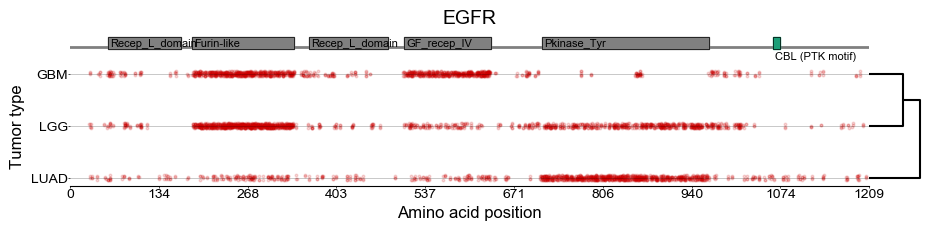

In [6]:
gene = "EGFR"
df_degrons = pd.read_csv(f"source_data/annotated_degrons_{gene}.tsv",sep="\t")
df_pfam = pd.read_csv(f"source_data/PFAM_domains_{gene}.tsv",sep="\t")
with open(f"source_data/blueprint_info_{gene}.pickle",'rb') as f:
    all_pred_specific=pickle.load(f)
_ = plot_clustering_reformat(gene, 'raw_plots', all_pred_specific, dpi=600, plot=True)
